In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from PIL import Image
import time
import os
import copy
import pandas as pd
from tqdm import tqdm, tqdm_notebook
from scipy import stats
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    ]),
    'val': transforms.Compose([
#         transforms.Resize(input_size),
#         transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
def plcc(x, y):
    """Pearson Linear Correlation Coefficient"""
    x, y = np.float32(x), np.float32(y)
    return stats.pearsonr(x, y)[0]
device  = torch.device("cpu")


PyTorch Version:  1.12.1+cu102
Torchvision Version:  0.13.1+cu102


In [2]:
def train_model(model,optimizer,batch_size, num_epochs=40):
    ids = pd.read_csv('./koniq10k_distributions_sets.csv')
    data_dir='./512x384'
    ids_train = ids[ids.set=='training']
    ids_val = ids[ids.set=='validation'].reset_index()
#     ids_test = ids[ids.set=='test'].reset_index()
    since = time.time()

    val_plcc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_plcc = -float('inf')

    for epoch in  (range(num_epochs)):
        ids_train_shuffle = ids_train.sample(frac=1).reset_index()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                num_batches = np.int(np.ceil(len(ids_train)/batch_size))

            else:
                model.eval()   # Set model to evaluate mode
                num_batches = np.int(np.ceil(len(ids_val)/batch_size))

            running_loss = 0.0
            running_plcc = 0.0
            # Iterate over data.
#             for k in tqdm_notebook(range(0,num_batches)):
            for k in range(0,num_batches):

                if phase == 'train': 
                    ids_cur=ids_train_shuffle
                else:
                    ids_cur=ids_val

                batch_size_cur=min(batch_size,len(ids_cur)-k*batch_size)
                img_batch=torch.zeros(batch_size_cur,3,384,512).to(device)   
                for i in range(batch_size_cur):  
                    img_batch[i]=data_transforms[phase](Image.open(os.path.join(data_dir,ids_cur['image_name'][k*batch_size+i])))  
                label_batch=torch.tensor(list(ids_cur['MOS'][k*batch_size:k*batch_size+batch_size_cur])).to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(img_batch)
#                     print(outputs)
                    loss = torch.nn.MSELoss()(outputs, label_batch.unsqueeze(1))
                    if phase=='val':
                        plcc_batch=plcc(label_batch.detach().cpu().numpy(),outputs.squeeze(1).detach().cpu().numpy())
#                     loss = torch.nn.MSELoss()(outputs, label_batch)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * img_batch.size(0)
                if phase=='val':
                    running_plcc += plcc_batch * img_batch.size(0)


            if phase == 'train':
                epoch_loss = running_loss / len(ids_train)
                print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            else:
                epoch_loss = running_loss / len(ids_val)
                epoch_plcc = running_plcc / len(ids_val)
                print('{} Loss: {:.4f} Plcc: {:.4f}'.format(phase, epoch_loss,epoch_plcc))

            # deep copy the model
            if phase == 'val' and epoch_plcc > best_plcc:
                best_plcc = epoch_plcc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_plcc_history.append(epoch_plcc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_plcc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_plcc_history



from inceptionresnetv2 import inceptionresnetv2
class model_qa(nn.Module):
    def __init__(self,num_classes,**kwargs):
        super(model_qa,self).__init__()
        base_model = inceptionresnetv2(num_classes=1000, pretrained=False)
        self.base= nn.Sequential(*list(base_model.children())[:-1])
        self.fc = nn.Sequential(
            nn.Linear(1536, 2048),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(2048),
            nn.Dropout(p=0.25),
            nn.Linear(2048, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 256),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(256),         
            nn.Dropout(p=0.5),
            nn.Linear(256, num_classes),
        )

    def forward(self,x):
        x = self.base(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x    

In [3]:
    
    
# model_ft=model_qa(num_classes=1) 
# model_ft=model_ft.to(device)
 
    
# optimizer_1 = optim.Adam(model_ft.parameters(), lr=1e-4)
# model_ft_1, val_plcc_history_1=train_model(model_ft, optimizer_1, batch_size=16,num_epochs=40)
# torch.save(model_ft_1.state_dict(),'./model_ft_1.pth')


# optimizer_2 = optim.Adam(model_ft_1.parameters(), lr=1e-4/5)
# KonCept512, val_plcc_history_2=train_model(model_ft_1, optimizer_2,batch_size=16, num_epochs=20)
# torch.save(KonCept512.state_dict(),'./KonCept512.pth')

In [4]:
from platform import python_version

print(python_version())

3.8.10


In [5]:
# KonCept512 = torch.load('./KonCept512.pth', map_location=torch.device('cpu')) 
KonCept512= model_qa(num_classes=1) 
KonCept512.load_state_dict(torch.load('./KonCept512.pth', map_location=torch.device('cpu')))
KonCept512.eval()

model_qa(
  (base): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
 

/tmp/ipykernel_21537/279943894.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(0,num_batches)):


  0%|          | 0/1008 [00:00<?, ?it/s]

SRCC: 0.912 | PLCC: 0.927 | MAE: 5.454 | RMSE: 7.124


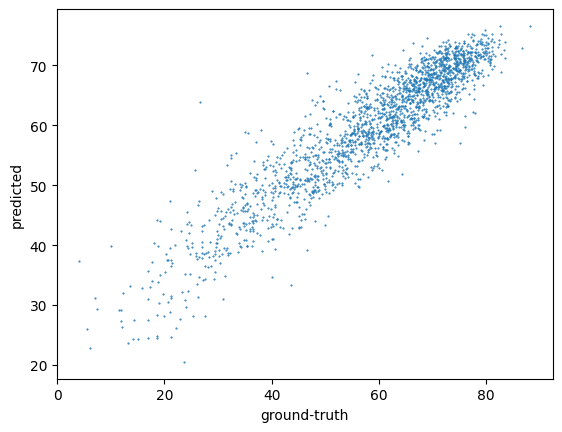

(0.912, 0.927, 5.454, 7.124)

In [6]:
### Test model on the default test set
# KonCept512 = torch.load('./KonCept512.pth', map_location=torch.device('cpu'))) 
# # KonCept512.load_state_dict(torch.load('./KonCept512.pth'))
# KonCept512.eval().to(device)
def srocc(xs, ys):
    """Spearman Rank Order Correlation Coefficient"""
    xranks = pd.Series(xs).rank()    
    yranks = pd.Series(ys).rank()    
    return plcc(xranks, yranks)
def rating_metrics(y_true, y_pred, show_plot=True):    
    """
    Print out performance measures given ground-truth (`y_true`) and predicted (`y_pred`) scalar arrays.
    """
    y_true, y_pred = np.array(y_true).squeeze(), np.array(y_pred).squeeze()
    p_plcc = np.round(plcc(y_true, y_pred),3)
    p_srocc = np.round(srocc(y_true, y_pred),3)
    p_mae  = np.round(np.mean(np.abs(y_true - y_pred)),3)
    p_rmse  = np.round(np.sqrt(np.mean((y_true - y_pred)**2)),3)
    
    if show_plot:
        print('SRCC: {} | PLCC: {} | MAE: {} | RMSE: {}'.\
              format(p_srocc, p_plcc, p_mae, p_rmse))    
        plt.plot(y_true, y_pred,'.',markersize=1)
        plt.xlabel('ground-truth')
        plt.ylabel('predicted')
        plt.show()
    return (p_srocc, p_plcc, p_mae, p_rmse)

ids = pd.read_csv('./koniq10k_distributions_sets.csv')
data_dir='./512x384'
ids_train = ids[ids.set=='training'].reset_index()
ids_val = ids[ids.set=='validation'].reset_index()
ids_test = ids[ids.set=='test'].reset_index()

batch_size=2
num_batches = np.int(np.ceil(len(ids_test)/batch_size))


# Iterate over data.
outputs=np.zeros((len(ids_test),1))
for k in tqdm_notebook(range(0,num_batches)):
    batch_size_cur=min(batch_size,len(ids_test)-k*batch_size)
    img_batch=torch.zeros(batch_size_cur,3,384,512).to(device)   
    for i in range(batch_size_cur):  
        img_batch[i]=data_transforms['val'](Image.open(os.path.join(data_dir,ids_test['image_name'][k*batch_size+i])))  
    label_batch=torch.tensor(list(ids_test['MOS'][k*batch_size:k*batch_size+batch_size_cur]))
    outputs[k*batch_size:k*batch_size+batch_size_cur] = KonCept512(img_batch).detach().cpu().numpy()
 



y_true = ids[ids.set=='test'].MOS.values
rating_metrics(y_true, outputs)